# Speech Understanding 
# Lecture 8: Fundamentals of Audio


### Mark Hasegawa-Johnson, KCGI, December 3, 2022

Today's lecture is catch-up.
* We will cover fundamental audio concepts that you may have missed.
* For homework, please complete the homework assignments from lectures 4, 5, and 6.

Here are the contents:
1. <a href="#section_samplingrate">Sampling Rate</a>
1. <a href="#section_frequency">Frequency</a>
1. <a href="#section_fft">FFT: Fast Fourier Transform</a>


<a id='section_samplingrate'></a>

## 1.  Sampling Rate

#### What is sound?

Sound is the variation of air pressure, as a function of time.  It propagates through air like this:

https://upload.wikimedia.org/wikipedia/commons/6/62/Onde_compression_impulsion_1d_30_petit.gif

#### How do we listen to sound on a computer?

In order to listen to sound on a computer, the sound must be **sampled**.  A sampled audio is one that has been converted to a sequence of numbers, like this:

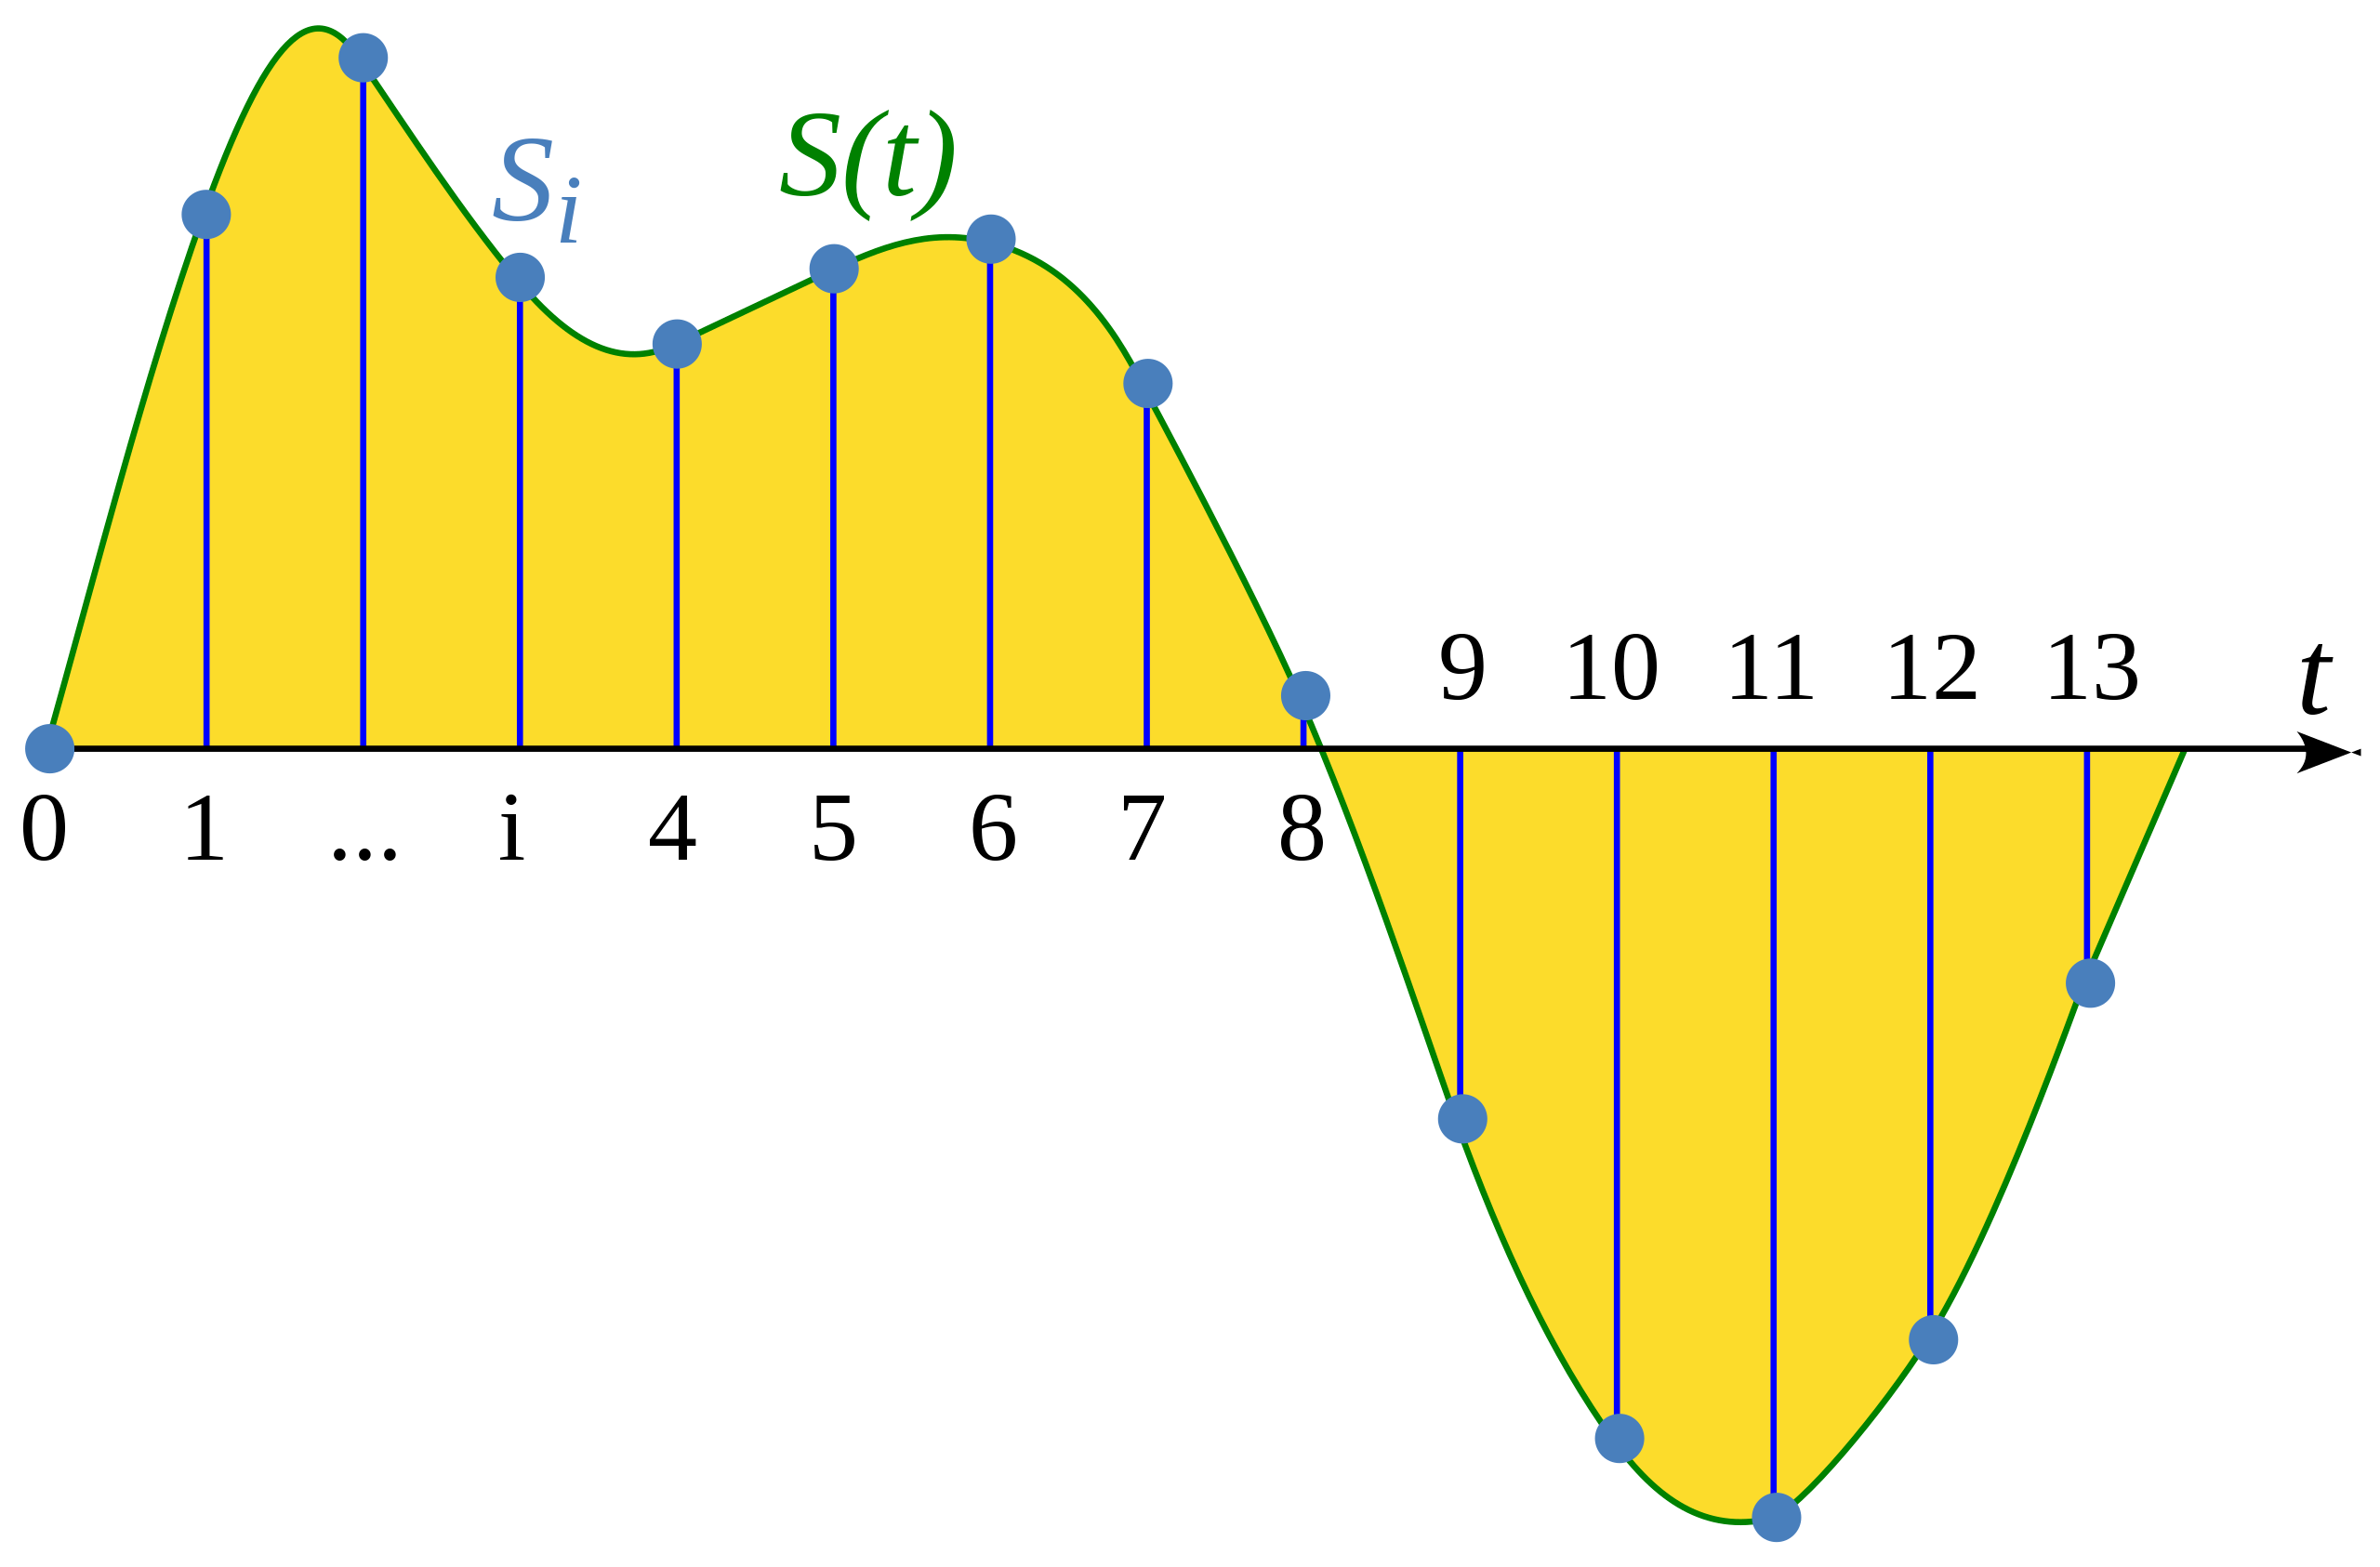

#### How many samples per second?

The number of samples per second is called the **sampling rate**.  When you load in a sound file, you will always load in two pieces of information:
* The **waveform** is an array of numbers
* Tha **sampling rate** is an integer


In [11]:
import urllib.request, io, soundfile
example_url = "https://catalog.ldc.upenn.edu/desc/addenda/LDC93S1.wav"
web_data = io.BytesIO(urllib.request.urlopen(example_url).read())

waveform, sampling_rate = soundfile.read(web_data)

print('The web data has sampling rate of',sampling_rate,'samples per second')
print('The first five samples are',waveform[:5])

The web data has sampling rate of 16000 samples per second
The first five samples are [ 3.05175781e-05 -3.05175781e-05  6.10351562e-05  0.00000000e+00
  0.00000000e+00]


In [17]:
import IPython
IPython.display.Audio(data=waveform, rate=16000)

#### What happens if we change the sampling rate?

If you change the sampling rate, then the sound is played back at a different speed.

In [19]:
import IPython
IPython.display.Audio(data=waveform, rate=8000)

In [18]:
import IPython
IPython.display.Audio(data=waveform, rate=24000)

#### Can we see the individual samples?

* If you want to plot the waveform as a curve, use `matplotlib.pyplot.plot`.
* If you want to plot the individual samples, use `matplotlib.pyplot.stem`.

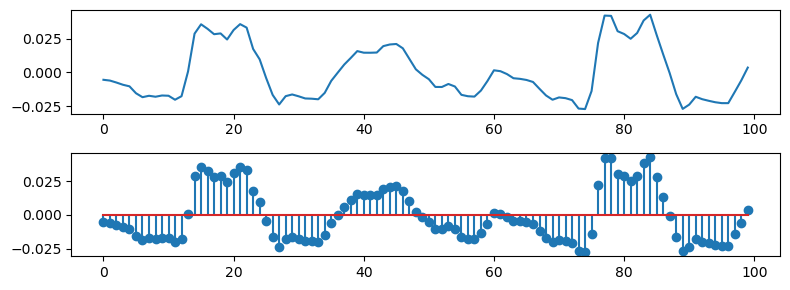

In [48]:
import matplotlib.pyplot
fig = matplotlib.pyplot.figure(figsize=(8,3))
axislist = fig.subplots(2,1)
axislist[0].plot(waveform[7000:7100])
axislist[1].stem(waveform[7000:7100])
fig.tight_layout()

#### What is the correspondence between sample numbers and seconds?

Notice that, in the figures above, the horizontal axis is in terms of **sample numbers**.  There are 100 samples, so the axis goes from 0 to 100.

If you want the horizontal axis in terms of **seconds**, you have to make the conversion yourself.  The conversion is:

$$t \left[\mbox{seconds}\right] = \frac{n \left[\mbox{sample number}\right]}{\mbox{sampling_rate} \left[\mbox{samples}/\mbox{second}\right]}$$


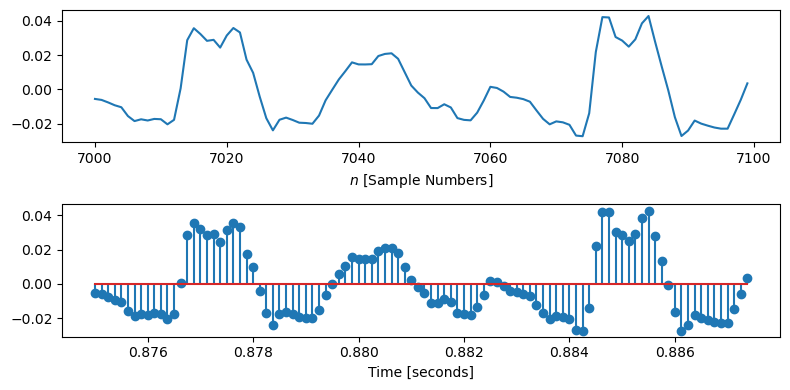

In [49]:
import numpy, matplotlib.pyplot

sample_numbers = numpy.arange(7000,7100)
time = sample_numbers / sampling_rate

fig = matplotlib.pyplot.figure(figsize=(8,4))
axislist = fig.subplots(2,1)
axislist[0].plot(sample_numbers, waveform[sample_numbers])
axislist[0].set_xlabel('$n$ [Sample Numbers]')
axislist[1].stem(time, waveform[sample_numbers])
axislist[1].set_xlabel('Time [seconds]')
fig.tight_layout()

<a id='section_frequency'></a>

## 2. Frequency

The cosine and the sine of an angle are defined like this:

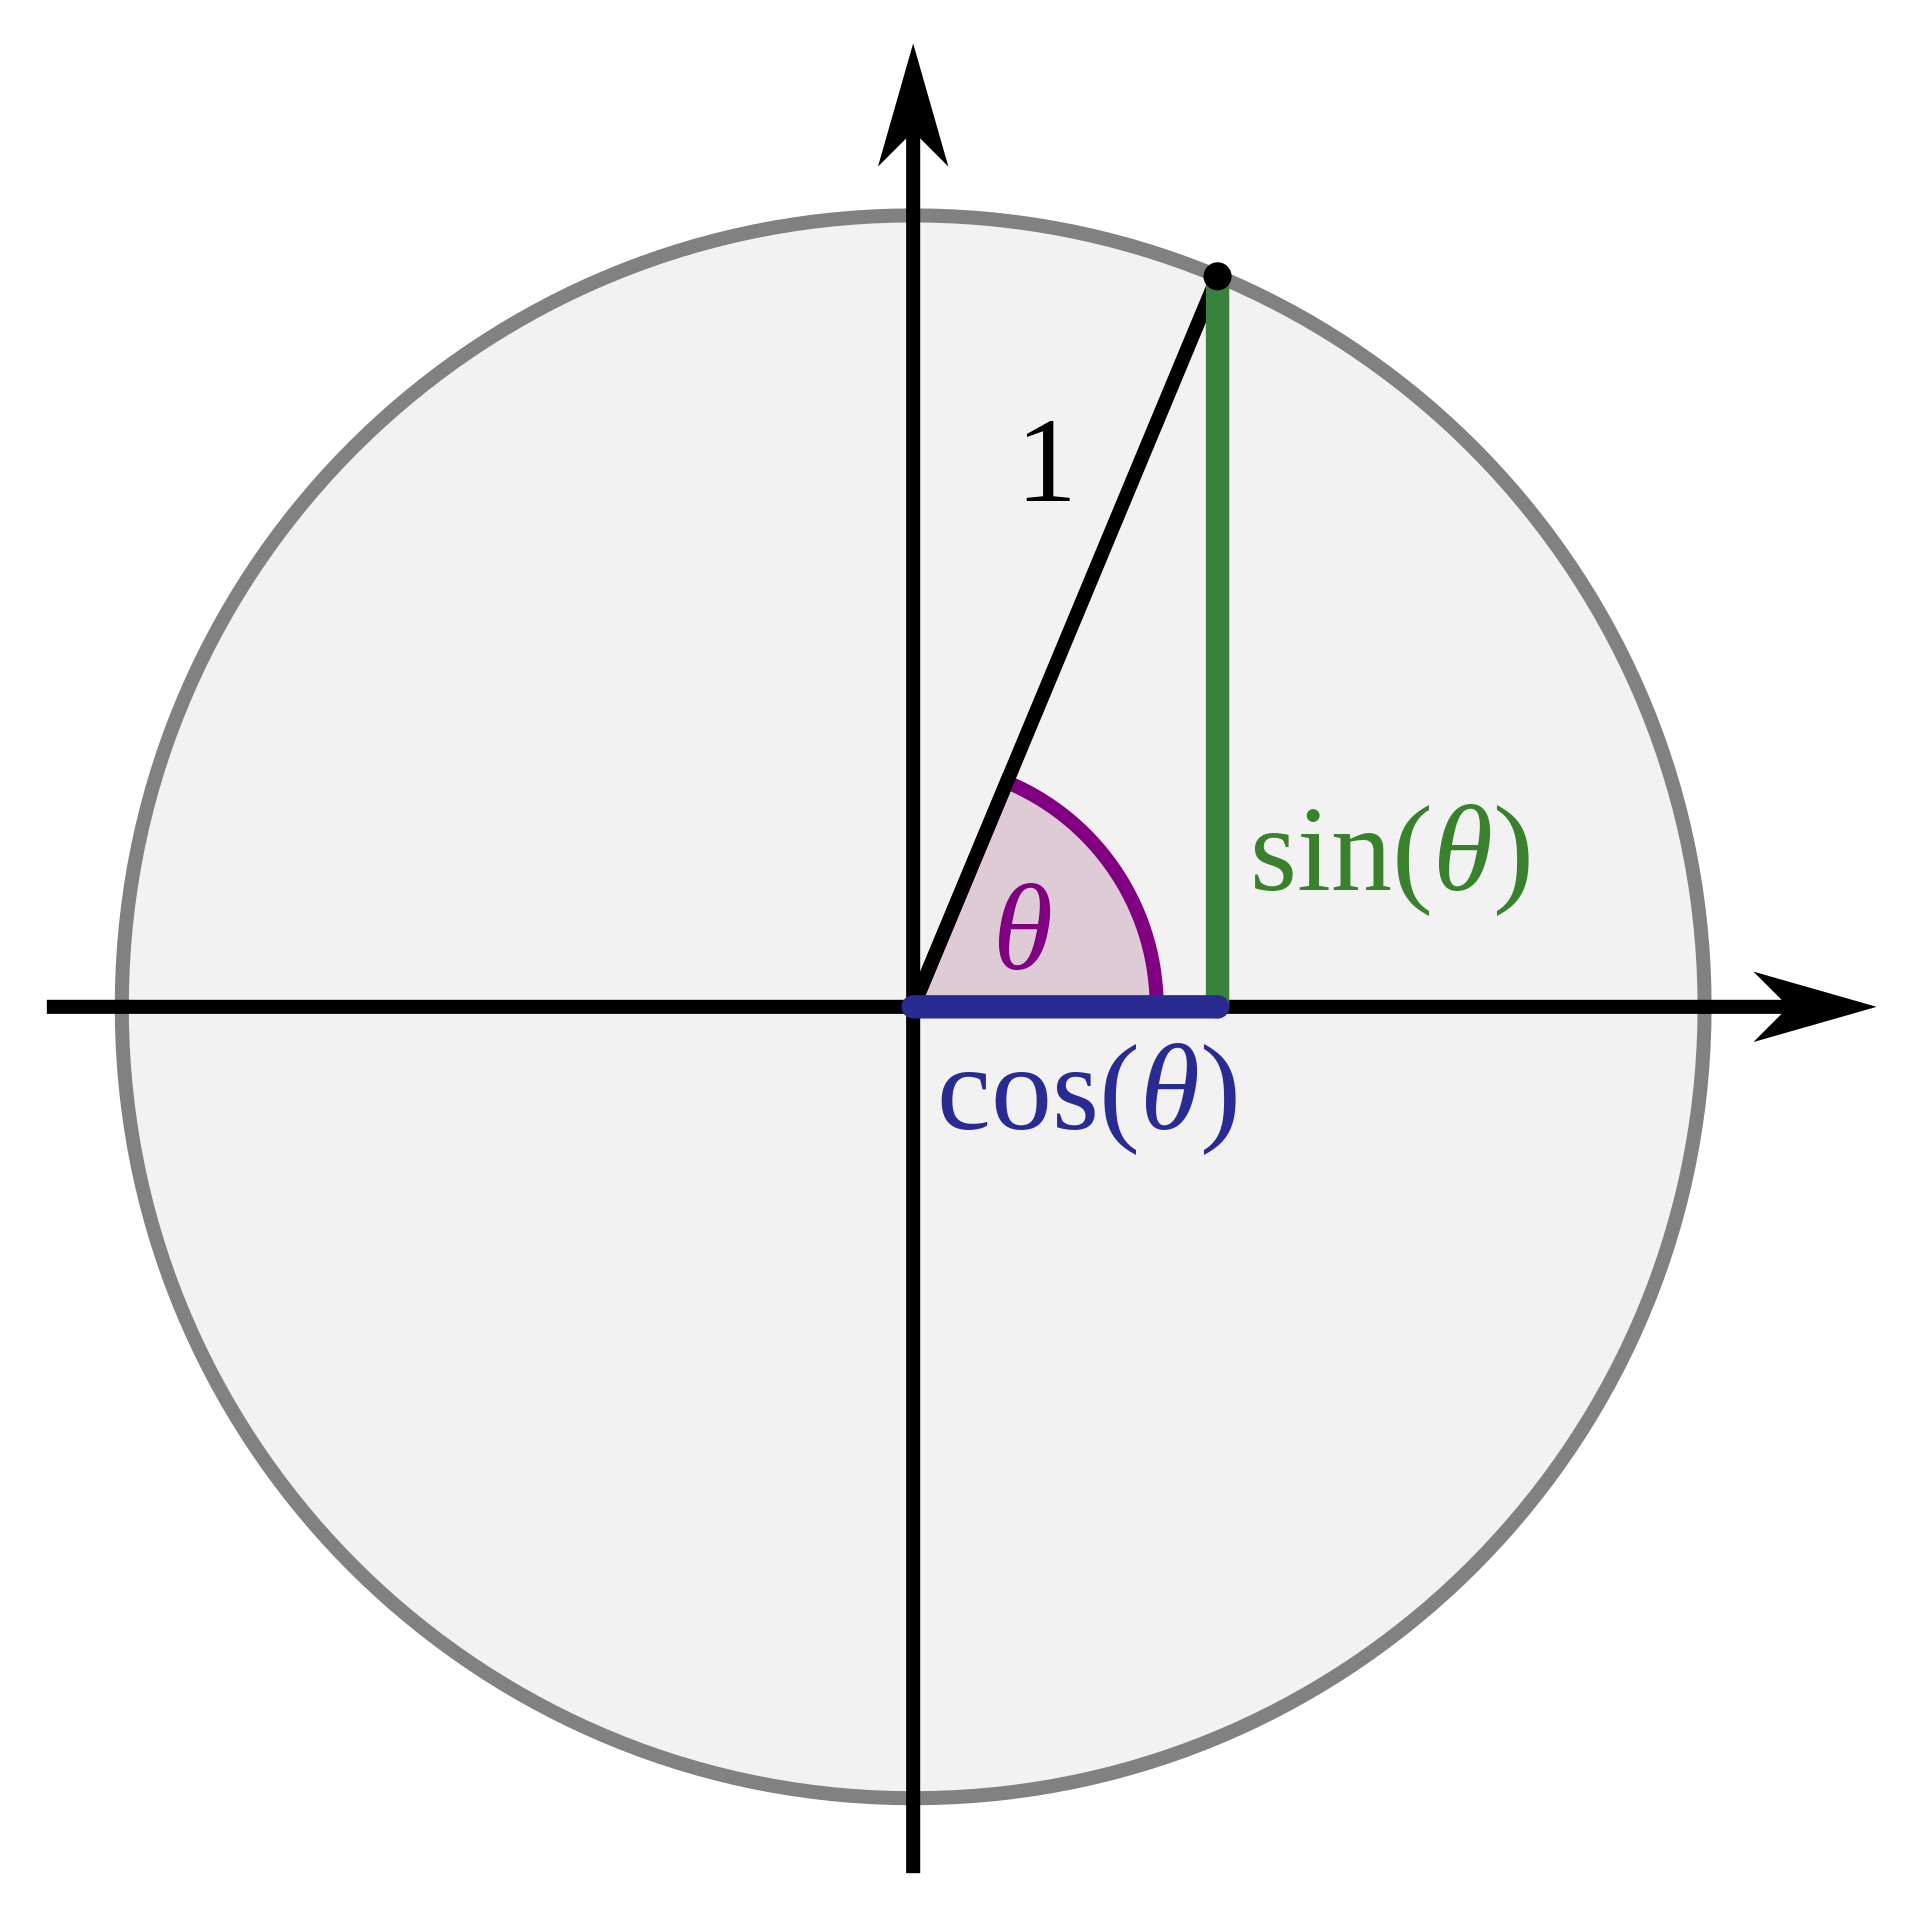

#### The argument of the sine is always an angle

The argument of a sine is always an angle, measured in radians:

$$y=\sin(\theta),~~~\theta=\mbox{angle}\left[\mbox{radians}\right]$$

#### What is **frequency**?

Frequency is the number of times, per second, that we go around the circle:

https://en.wikipedia.org/wiki/Sine_and_cosine#/media/File:Circle_cos_sin.gif

Frequency ($f$) is related to angle according to the following formula:

$$\theta\left[\mbox{radians}\right] =
2\pi \left[\mbox{radians/cycle}\right] \times
f \left[\mbox{cycles/second}\right] \times
t \left[\mbox{seconds}\right]$$


#### How is **angle** computed from **frequency** and **sampling_rate**?

Remember that
$$t \left[\mbox{seconds}\right] = \frac{n \left[\mbox{sample number}\right]}{\mbox{sampling_rate} \left[\mbox{samples}/\mbox{second}\right]}$$

Combining these two equations, we get that

$$\theta\left[\mbox{radians}\right] =
2\pi \left[\mbox{radians/cycle}\right] \times
f \left[\mbox{cycles/second}\right] \times
\frac{n \left[\mbox{sample number}\right]}{\mbox{sampling_rate} \left[\mbox{samples}/\mbox{second}\right]}$$

##### How is frequency related to music?

The pitch of a musical instrument is **completely** determined by its frequency.  For example, 440 cycles/second is the middle A of a piano:

https://en.wikipedia.org/wiki/A440_(pitch_standard)

In [46]:
import numpy, IPython

sampling_rate = 8000
n = numpy.arange(0,2000)
t = n / sampling_rate

f = 440
theta = 2 * numpy.pi * f * t

A440_pure_tone = numpy.sin(theta)

IPython.display.Audio(data=A440_pure_tone, rate=8000)

We can plot the sine wave as a function of:
* sample number [samples], or
* time [seconds], or
* angle [radians]

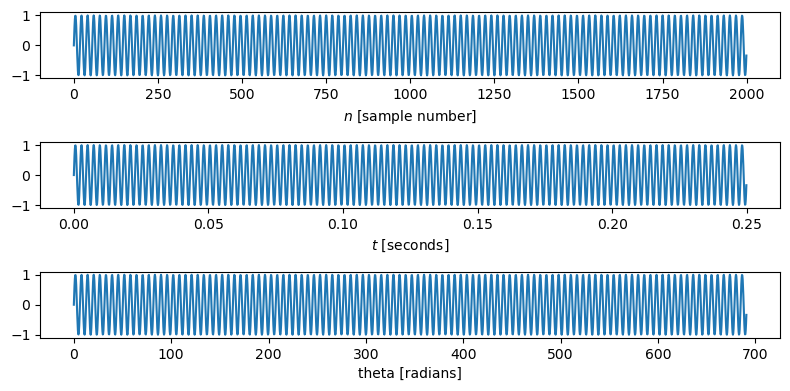

In [52]:
import matplotlib.pyplot
fig = matplotlib.pyplot.figure(figsize=(8,4))
axis_list = fig.subplots(3,1)
axis_list[0].plot(n, A440_pure_tone)
axis_list[0].set_xlabel('$n$ [sample number]' )
axis_list[1].plot(t, A440_pure_tone)
axis_list[1].set_xlabel('$t$ [seconds]')
axis_list[2].plot(theta, A440_pure_tone)
axis_list[2].set_xlabel('theta [radians]')
fig.tight_layout()

#### Do we have to write all of those things every time?

No.  Usually we just write all of that information on one line, like this:

In [54]:
import numpy as np

A440_pure_tone = np.sin(2*np.pi*440*np.arange(0,2000)/8000)

IPython.display.Audio(data=A440_pure_tone, rate=8000)

<a id='section_fft'></a>

## 3. FFT: Fast Fourier Transform

Suppose you want to know **which frequencies** a signal has.  The way you find out is by using the **fast Fourier transform (FFT)**.


### 3.1 If a waveform has $N$ samples, then its FFT has $N$ bins

In [64]:
print('The length of the waveform is',len(A440_pure_tone),'samples')

import numpy as np
A440_fft = np.fft.fft(A440_pure_tone)
print('The length of its FFT is',len(A440_fft),'bins')

The length of the waveform is 2000 samples
The length of its FFT is 2000 bins


### 3.2 The FFT is complex valued! 

Every bin of the FFT is complex valued: It has a real part, and an imaginary part.


In [65]:
print('The first three bins of the FFT are',A440_fft[:3])

The first three bins of the FFT are [ 3.05543037e-13+0.0000000e+00j  3.36183784e-14+8.9384970e-14j
 -8.85692681e-14-1.4466206e-13j]


### 3.3 The **spectrum** is the absolute value of the FFT

Usually, what you wanted was the absolute value, which we usually call the **spectrum**.  The absolute value of a complex number is:

$$\mbox{abs}(\mbox{fft}) = \sqrt{
\left(\mbox{real}(\mbox{fft})\right)^2+
\left(\mbox{imaginary}(\mbox{fft})\right)^2}$$

The function `numpy.abs` will calculate this for you.

In [73]:
A440_spectrum = np.abs(A440_fft)
print('The first three bins of the spectrum are',A440_spectrum[:3])

The first three bins of the spectrum are [3.05543037e-13 9.54980012e-14 1.69622012e-13]


### 3.4 The relationship between bin number and frequency

Remember that there are $N$ bins?  So to convert from bin number to frequency, you use

$$f \left[\mbox{cycles/second}\right] =
k \left[\mbox{bin number}\right] \times
\frac{\mbox{sampling_rate} \left[\mbox{samples/second}\right]}
{N \left[\mbox{bin numbers}\right]}$$

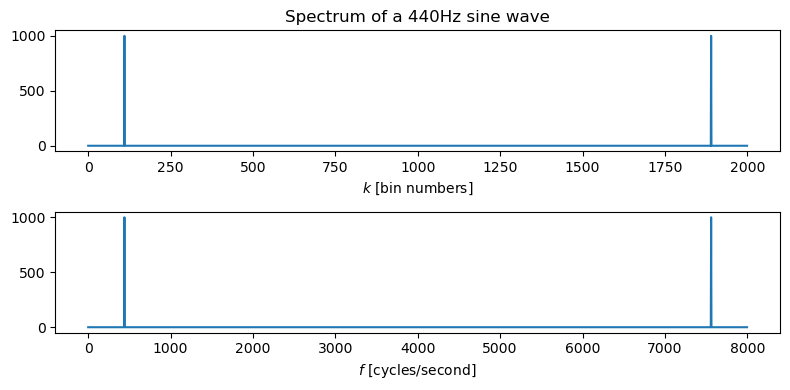

In [76]:
N = len(A440_spectrum)
k = np.arange(N)

f = k * sampling_rate/N

fig = matplotlib.pyplot.figure(figsize=(8,4))
axis_list = fig.subplots(2,1)
axis_list[0].plot(k,A440_spectrum)
axis_list[0].set_xlabel('$k$ [bin numbers]')
axis_list[0].set_title('Spectrum of a 440Hz sine wave')
axis_list[1].plot(f, A440_spectrum)
axis_list[1].set_xlabel('$f$ [cycles/second]')
fig.tight_layout()


### 3.5 A sine wave at frequency $f$ also has energy at frequency $F_s-f$

Notice, in the plot above, that the sine wave at 440 Hertz also has energy at frequency $8000-440=7560$ Hertz.  We can zoom in on both of those frequencies, to see them more closely.

In [ ]:
fig = matplotlib.pyplot.figure(figsize=(8,4))
axis_list = fig.subplots(2,1)
axis_list[0].plot(f,A440_spectrum)
axis_list[0].set_xlabel('$f$ [Hertz]=[cycles/second]')
axis_list[0].set_title('Spectrum of a 440Hz sine wave')

axis_list[1].plot(f, A440_spectrum)
axis_list[1].set_xlabel('$f$ [cycles/second]')
fig.tight_layout()

<a id='section_recognition'></a>

## Homework for Week 8

Go back and do the homeworks for weeks 4, 5, and 6.